## House Price Prediction - Assignment Solution

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation

### 1. Data Understanding and Exploration

Let's first import the required libraries and have a look at the dataset and understand the size, attribute names etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the dataset
house = pd.read_csv("train.csv", na_values="NAN")

In [4]:
# Let's take a look at the first few rows
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Summary of the dataset : 1460 rows, 81 columns

<Axes: xlabel='SalePrice', ylabel='Density'>

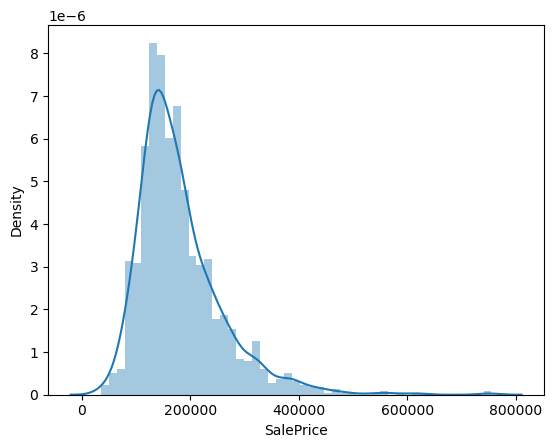

In [7]:
sns.distplot(house['SalePrice'])

In [8]:
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


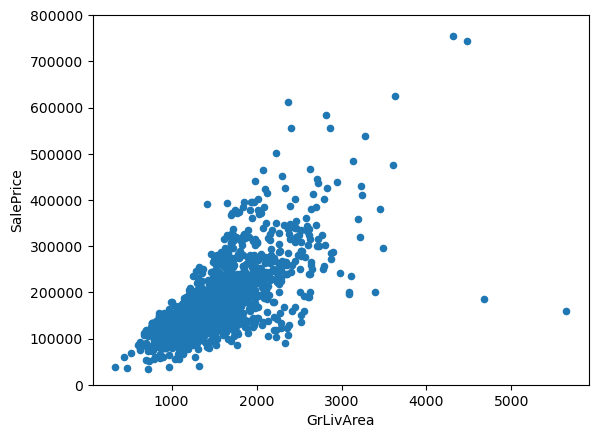

In [9]:
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

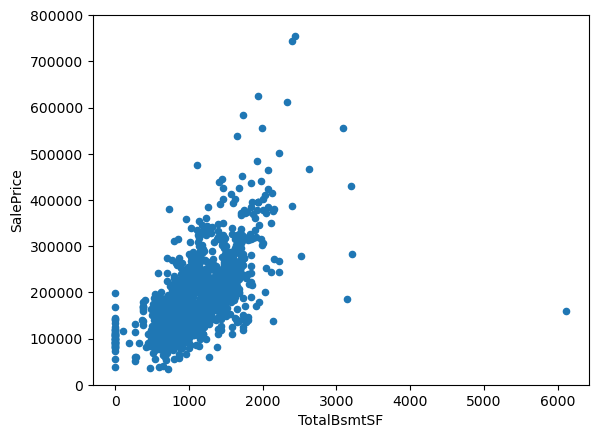

In [10]:
var = 'TotalBsmtSF'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

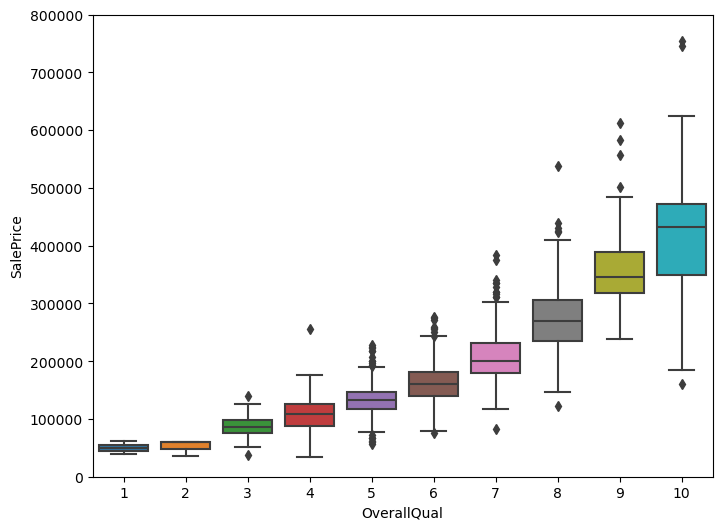

In [11]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

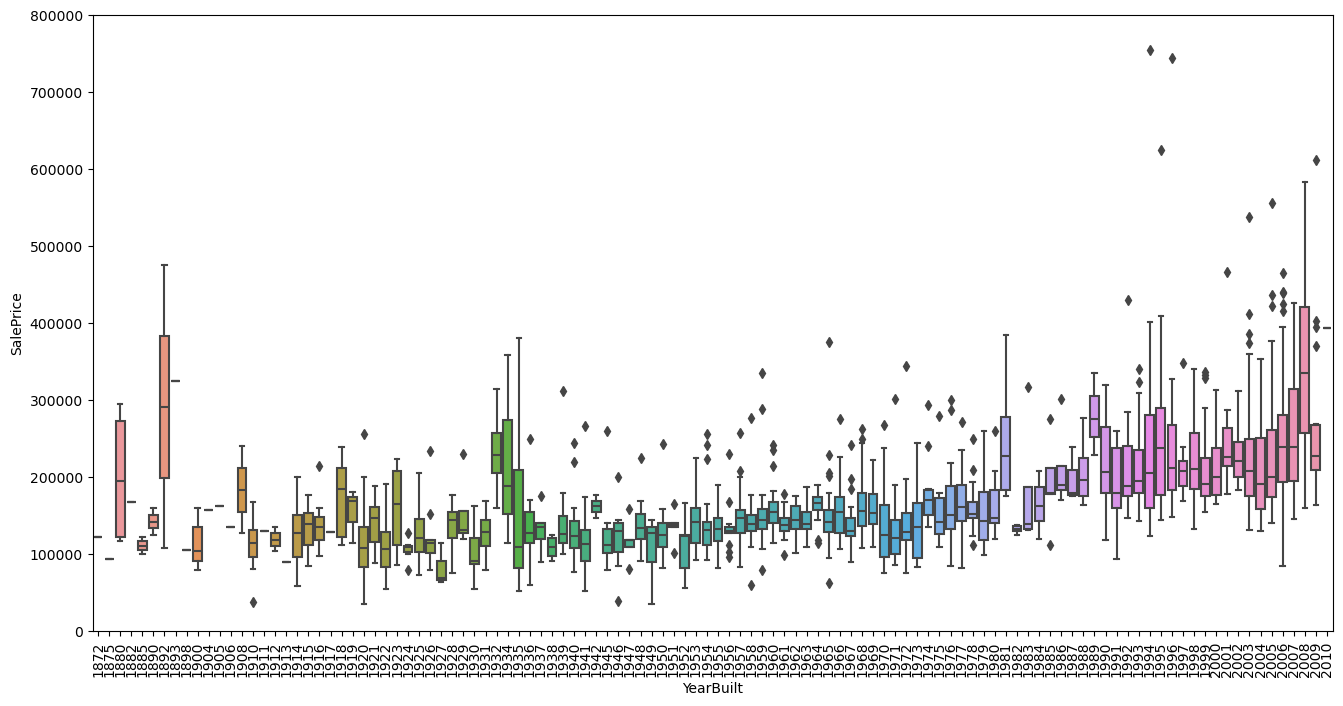

In [12]:
var = 'YearBuilt'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [13]:
#correlation matrix
corrmat = house.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

ValueError: could not convert string to float: 'RL'

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

# Missing data

Important questions when thinking about missing data:

How prevalent is the missing data?
Is missing data random or does it have a pattern?
The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

## Imputing Null Values
With data this large, it is not surprising that there are a lot of missing values in the cells. In order to effectively train our model we build, we must first deal with the missing values. There are missing values for both numerical and categorical data. We will see how to deal with both.

For numerical imputing, we would typically fill the missing values with a measure like median, mean, or mode. For categorical imputing, I chose to fill the missing values with the most common term that appeared from the entire column. There are other ways to do the imputing though, and I ecnourage you to test out your own creative ways!

### Places Where NaN Means Something
If you look at the data description file provided, you will see that for some categories, NaN actually means something. This means that if a value is NaN, the house might not have that certain attribute, which will affect the price of the house. Therefore, it is better to not drop, but fill in the null cell with a value called "None" which serves as its own category.

In [ ]:
#you can find these features on the description data file provided

null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [ ]:
for i in null_has_meaning:
    house[i].fillna("None", inplace=True)
    house[i].fillna("None", inplace=True)

## Imputing "Real" NaN Values

These are the real NaN values that we have to deal with accordingly because they were not recorded.

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

LotFrontage has too many Null values and it is a numerical value so it may be better to just drop it.

In [ ]:
house.drop("LotFrontage", axis=1, inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

GarageYrBlt, MasVnrArea, and MasVnrType all have a fairly decent amount of missing values. MasVnrType is categorical so we can replace the missing values with "None", as we did before. We can fill the others with median.

In [ ]:
house["GarageYrBlt"].fillna(house["GarageYrBlt"].median(), inplace=True)
house["MasVnrArea"].fillna(house["MasVnrArea"].median(), inplace=True)
house["MasVnrType"].fillna("None", inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

Now that only one row has a null entry, we will drop the row.

In [ ]:
house.dropna(inplace=True)

In [ ]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

In [ ]:
print(house.info())

### Now we will determine the data type of all features remaining

In [ ]:
types_train = house.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == 'int64') | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object

In [ ]:
pd.DataFrame(types_train).reset_index().set_index(0).reset_index()[0].value_counts()

In [ ]:
# we should convert num_train to a list to make it easier to work with
numerical_values_train = list(num_train.index)

In [ ]:
print(numerical_values_train)

These are all the numerical features in our data.

In [ ]:
categorical_values_train = list(cat_train.index)
print(categorical_values_train)

These are all the caregorical features in our data.

# Data Preparation

Ok, now that we have dealt with all the missing values, it looks like it's time for some feature engineering, the second part of our data preprocessing. We need to create feature vectors in order to get the data ready to be fed into our model as training data. This requires us to convert the categorical values into representative numbers.

In [ ]:
sns.distplot(house["SalePrice"])

In [ ]:
sns.distplot(np.log(house["SalePrice"]))

It appears that the target, SalePrice, is very skewed and a transformation like a logarithm would make it more normally distributed. Machine Learning models tend to work much better with normally distributed targets, rather than greatly skewed targets. By transforming the prices, we can boost model performance.

In [ ]:
house["TransformedPrice"] = np.log(house["SalePrice"])

In [ ]:
print(categorical_values_train)

In [ ]:
for i in categorical_values_train:
    feature_set = set(house[i])
    for j in feature_set:
        feature_list = list(feature_set)
        house.loc[house[i] == j, i] = feature_list.index(j)

In [ ]:
house.head()

Great! It seems like we have changed all the categorical strings into a representative number. We are ready to build our models!

# Model Building

Now that we've preprocessed and explored our data, we have a much better understanding of the type of data that we're dealing with. Now, we can began to build and test different models for regression to predict the Sale Price of each house.

In [ ]:
X = house.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values
y = house["TransformedPrice"].values

In [ ]:
# split into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size = 0.3, random_state=100)

In [ ]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

In [ ]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [ ]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

In [ ]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [ ]:
alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

In [ ]:
lasso.coef_

In [ ]:
# Applying Ridge
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

In [ ]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [ ]:
alpha = 0.1
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_